In [1]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  mean_squared_error

R =pd.read_csv('long_series_logret.csv',index_col=0)
R.index = pd.DatetimeIndex(R.index)

year = 252
r = (R[R.index.year>2005].values*year).T[0] #Just for convinience I annualized the returns

In [2]:
#In-sample and out-of-sample window size
tin,tout = 1500,5

In [3]:
t = 0

#fitting and GARCH(1,1) on the in-sample window
Model = arch_model(r[t:t+tin], vol='GARCH', p=1,q=1,dist='t')
fit = Model.fit(disp='off')

#get the parameters
parms = fit.params

In [4]:
help(fit.forecast)

Help on method forecast in module arch.univariate.base:

forecast(params: 'ArrayLike1D | None' = None, horizon: 'int' = 1, start: 'int | DateLike | None' = None, align: "Literal['origin', 'target']" = 'origin', method: 'ForecastingMethod' = 'analytic', simulations: 'int' = 1000, rng: 'Callable[[int | tuple[int, ...]], Float64Array] | None' = None, random_state: 'np.random.RandomState | None' = None, *, reindex: 'bool' = False, x: 'None | dict[Label, ArrayLike] | ArrayLike' = None) -> 'ARCHModelForecast' method of arch.univariate.base.ARCHModelResult instance
    Construct forecasts from estimated model
    
    Parameters
    ----------
    params : ndarray, optional
        Alternative parameters to use.  If not provided, the parameters
        estimated when fitting the model are used.  Must be identical in
        shape to the parameters computed by fitting the model.
    horizon : int, optional
       Number of steps to forecast
    start : {int, datetime, Timestamp, str}, optional

In [5]:
fit.convergence_flag

0

In [6]:
parms

mu          0.243069
omega       0.687305
alpha[1]    0.074552
beta[1]     0.918357
nu          5.472575
Name: params, dtype: float64

In [7]:
#Convergence value of the conditional variance
conv = parms.loc['omega']/(1-parms.loc['alpha[1]']-parms.loc['beta[1]'])

conv

96.93134472322262

In [8]:
# Forecast of  500 time step analytically

forecast = fit.forecast(horizon=500,method='analytic',reindex=False)

In [9]:
help(fit.forecast)

Help on method forecast in module arch.univariate.base:

forecast(params: 'ArrayLike1D | None' = None, horizon: 'int' = 1, start: 'int | DateLike | None' = None, align: "Literal['origin', 'target']" = 'origin', method: 'ForecastingMethod' = 'analytic', simulations: 'int' = 1000, rng: 'Callable[[int | tuple[int, ...]], Float64Array] | None' = None, random_state: 'np.random.RandomState | None' = None, *, reindex: 'bool' = False, x: 'None | dict[Label, ArrayLike] | ArrayLike' = None) -> 'ARCHModelForecast' method of arch.univariate.base.ARCHModelResult instance
    Construct forecasts from estimated model
    
    Parameters
    ----------
    params : ndarray, optional
        Alternative parameters to use.  If not provided, the parameters
        estimated when fitting the model are used.  Must be identical in
        shape to the parameters computed by fitting the model.
    horizon : int, optional
       Number of steps to forecast
    start : {int, datetime, Timestamp, str}, optional

In [10]:
# Only the last row is the forecast, the columns are the lags
# The first element is the last in-sample estimate

forecast.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
1499,65.039378,65.265513,65.490044,65.712983,65.934341,66.154129,66.372359,66.589042,66.804188,67.017809,...,95.955484,95.962404,95.969274,95.976096,95.982869,95.989594,95.996272,96.002902,96.009486,96.016022


In [11]:
fit

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5009.80
Distribution:      Standardized Student's t   AIC:                           10029.6
Method:                  Maximum Likelihood   BIC:                           10056.2
                                              No. Observations:                 1500
Date:                      Mon, Sep 16 2024   Df Residuals:                     1499
Time:                              16:57:55   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

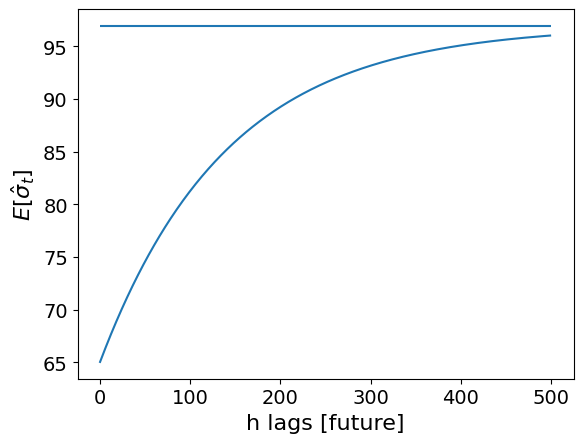

In [12]:
plt.plot( forecast.variance.iloc[-1].values )
plt.hlines(conv,0,500)
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'$E[\hat{\sigma}_t]$',fontsize=16)
plt.tick_params(labelsize=14)

In [13]:
t = 0

# define a GARCH(1,1) for in-sample
Model = arch_model(r[t:t+tin+tout], vol='GARCH', p=1,q=1,dist='t')
# fit only the in-sample time-window 
fit = Model.fit(disp='off',last_obs=tin)

# Simulate for the out-of-sample horizon, if 1000 sims are too much, just reduce it
forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation',reindex=True)

In [14]:
#forecast.simulations.variances

In [15]:
#only the last element are the simulations
forecast.simulations.variances.shape

(1505, 1000, 6)

In [16]:
forecast.simulations.variances[-1].shape

(1000, 6)

In [17]:
# Simulations are by rows, times is by column. The first column is the last in-sample observation
forecast.simulations.variances[-1].shape

(1000, 6)

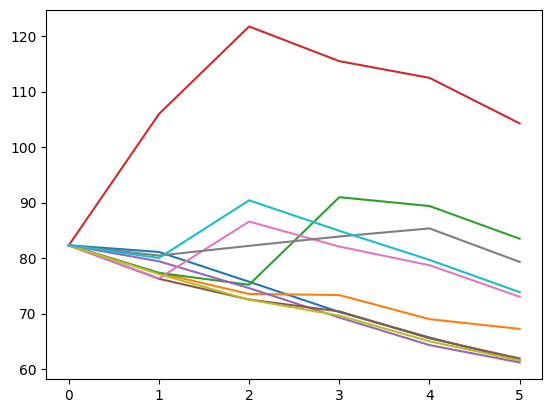

In [18]:
for i in range(10):
    plt.plot(forecast.simulations.variances[-1][i])


In [19]:
simulated = forecast.simulations.variances[-1][:,1:]

# Estimat the conditional variance by using the in-sample calibrated parameters
OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2

In [20]:
OOS_obs

array([65.03937814, 65.17158528, 60.59865831, 59.90096079, 73.82580906])

In [21]:
# Get a 90% confidence interval
minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)

# Get the mean (it can be computed also analytically)
mean = simulated.mean(axis=0)

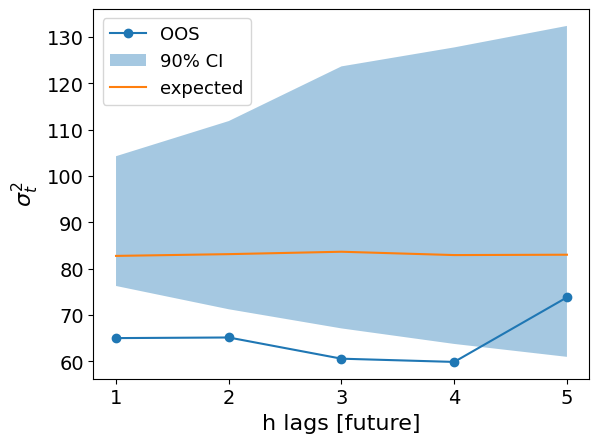

In [22]:

dx = np.arange(1,tout+1)
plt.plot(dx,OOS_obs,'-o',label='OOS')
plt.fill_between(dx,minCI,maxCI,alpha=0.4,label='90% CI')
plt.plot(dx,mean,label='expected')
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'$σ_t^2$',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',fontsize=13)

In [23]:
Coverage_GARCH,DIFF_GARCH = [],[]

# Sliding windows in step of 5 days
for t in range(0,1000,5):

    Model = arch_model(r[t:t+tin+tout], vol='GARCH', p=1,q=1,dist='t')
    fit = Model.fit(disp='off',last_obs=tin)
    
    #if 1000 are too much reduce it
    forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation',reindex=True)

    simulated = forecast.simulations.variances[-1][:,1:]
    
    OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2


    minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)
    expectation = simulated.mean(axis=0)

    # Computing if the observations fall inside the CI
    Coverage_GARCH.append( (OOS_obs>minCI)*(OOS_obs<maxCI) )
    
    # Computing the deviation from the expectation 
    DIFF_GARCH.append(OOS_obs-expectation)

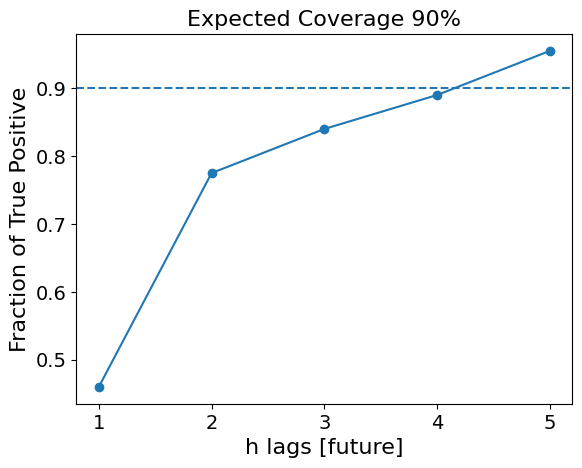

In [24]:
dx = np.arange(1,1+tout)
plt.plot(dx, np.mean(Coverage_GARCH,axis=0),'-o' )
plt.hlines(0.9,0,7,linestyles='--')
plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel('Fraction of True Positive',fontsize=16)
plt.tick_params(labelsize=14)

plt.title('Expected Coverage 90%',fontsize=16)
plt.show()


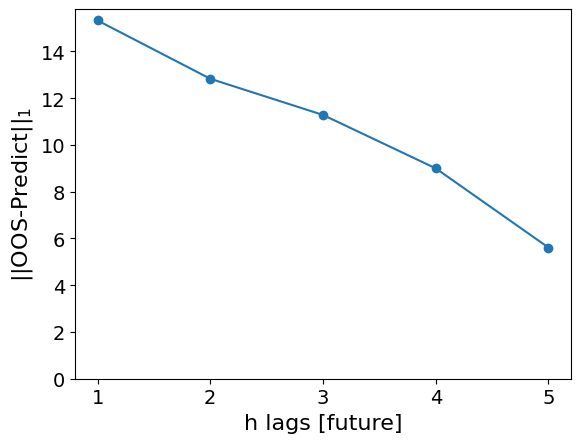

In [25]:
plt.plot( dx,abs(np.array(DIFF_GARCH)).mean(axis=0),'-o' ,label='GARCH(1,1)' )

plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'||OOS-Predict||$_1$',fontsize=16)
plt.tick_params(labelsize=14)

plt.ylim(ymin=0)
plt.show()

In [26]:
# The long-range predictions seems better


In [27]:
Coverage_ARCH,DIFF_ARCH = [],[]
for t in range(0,1000,5):

    #Fit with an ARCH(5)
    Model = arch_model(r[t:t+tin+tout], vol='ARCH', p=5,dist='t')
    fit = Model.fit(disp='off',last_obs=tin)
    
    #if 1000 are too much reduce it
    forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation',reindex=True)

    simulated = forecast.simulations.variances[-1][:,1:]
    
    OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2

    
    minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)
    mean = simulated.mean(axis=0)

    Coverage_ARCH.append( (OOS_obs>minCI)*(OOS_obs<maxCI) )
    DIFF_ARCH.append(OOS_obs-mean)

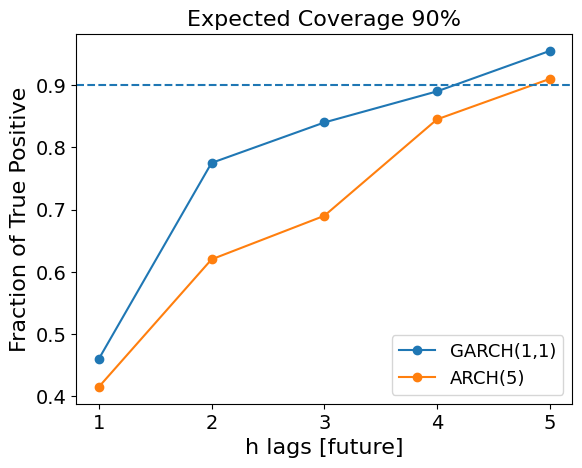

In [28]:
dx = np.arange(1,1+tout)
plt.plot(dx, np.mean(Coverage_GARCH,axis=0),'-o',label='GARCH(1,1)' )
plt.plot(dx, np.mean(Coverage_ARCH,axis=0),'-o',label='ARCH(5)' )
plt.hlines(0.9,0,7,linestyles='--')
plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel('Fraction of True Positive',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='lower right',fontsize=13)
plt.title('Expected Coverage 90%',fontsize=16)
plt.show()

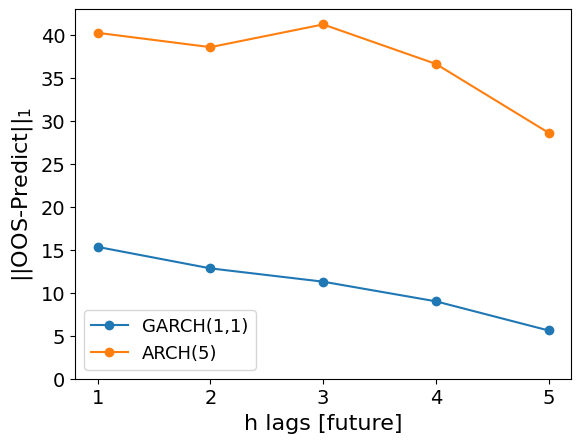

In [29]:
plt.plot( dx,abs(np.array(DIFF_GARCH)).mean(axis=0),'-o' ,label='GARCH(1,1)' )
plt.plot( dx,abs(np.array(DIFF_ARCH)).mean(axis=0),'-o' ,label='ARCH(5)' )

plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'||OOS-Predict||$_1$',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='best',fontsize=13)

plt.ylim(ymin=0)
plt.show()

In [30]:
# The GARCH(1,1) is clearly better then the ARCH(5)

In [31]:
# Please note that this is only an anecdotal example, you should not never assume it as a general rule.